## Load Data

In [12]:
import matplotlib.pyplot as plt

def plot_one_slice(img, cmap = 'gray'):
    plt.imshow(img, cmap=cmap)
    plt.show()

In [1]:
import os
import numpy as np

folder_path = "../cohort_new/numpy arrays"
file_list = os.listdir(folder_path)

data_list = []
for file_name in file_list:
    if file_name.endswith('.npy'):
        file_path = os.path.join(folder_path, file_name)  # Construct the full file path
        array = np.load(file_path).astype(float)          # Load the array and convert its type to float
        data_list.append(array) 

In [2]:
# Squeeze the arrays to remove the redundant dimension
data_list = [arr.squeeze() for arr in data_list]

heights = [arr.shape[1] for arr in data_list]
widths = [arr.shape[2] for arr in data_list]
slices = [arr.shape[0] for arr in data_list]

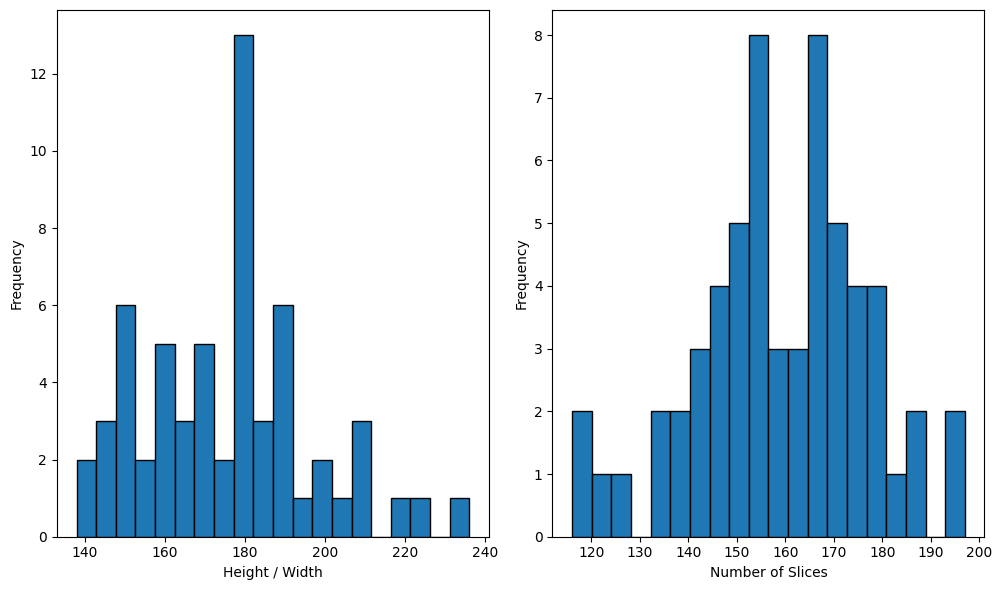

In [3]:
import matplotlib.pyplot as plt

# Create histograms of the heights, widths and slices

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.hist(heights, bins=20, edgecolor='black')
plt.xlabel('Height / Width')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(slices, bins=20, edgecolor='black')
plt.xlabel('Number of Slices')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Pad and Crop tensors

* We can do both at the same time using torch.nn.functional.pad function.

In [41]:
import torch
from torch import nn

In [5]:
sample = data_list[0]

In [88]:
print("Size of the raw 3D sample", sample.shape)

Size of the raw 3D sample (147, 171, 171)


In [46]:
sample_tensor = torch.from_numpy(sample)

In [98]:
# We can use the PyTorch function `nn.functional.interpolate` to resize the tensor
# We need to specify the padding size for each side of every dimension
# Negative padding means cropping
sample_resized = nn.functional.pad(sample_tensor, (50,50,50,50,0,0), "constant") 

In [99]:
print('Size of the resized tensor:', sample_resized.shape)

Size of the resized tensor: torch.Size([147, 271, 271])


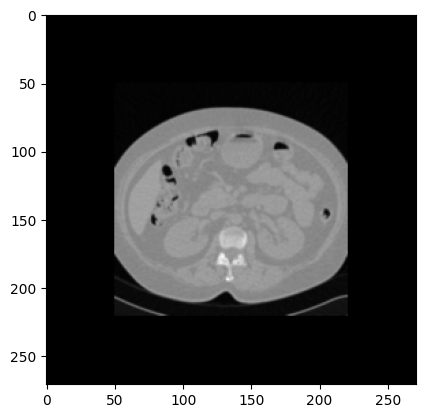

In [100]:
plot_one_slice(sample_resized[0])

## Resize the whole dataset

In [120]:
# Do the same for all the samples in the dataset
data_list_resized = []
output_size = (147, 224, 224)
for sample in data_list:
    sample_tensor = torch.from_numpy(sample)
    dz, dy, dx = np.subtract(output_size, sample_tensor.shape)

    dx_left = dx // 2
    dx_right = dx - dx_left
    dy_left = dy // 2
    dy_right = dy - dy_left
    dz_left = dz // 2
    dz_right = dz - dz_left

    sample_resized = nn.functional.pad(sample_tensor, (dx_left, dx_right, dy_left, dy_right, dz_left, dz_right), "constant")
    data_list_resized.append(sample_resized)

In [123]:
data_list_resized[20].shape

torch.Size([147, 224, 224])

## Test Training

### Create Data Loader

In [126]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        # Load and preprocess the data at the given index
        data = self.data_list[index]
        
        # Perform any necessary transformations or preprocessing on the data

        return data

In [125]:
# Create an instance of custom dataset
dataset = MyDataset(data_list_resized)

dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

### Create models

In [ ]:
import vision_transformer_3d_test as vit
from vision_transformer_3d_test import CLSHead, RECHead_3D
import torch.nn as nn

In [ ]:
class FullPipline(nn.Module):
    def __init__(self, backbone, head, head_recons):
        super(FullPipline, self).__init__()

        
        backbone.fc, backbone.head = nn.Identity(), nn.Identity()
        self.backbone = backbone
        self.head = head
        self.head_recons = head_recons

    def forward(self, x, recons=True):
        _out = self.backbone(x)
        
        if recons==True:
            print(_out[:, 1:].shape)
            return self.head(_out[:, 0]), self.head_recons(_out[:, 1:])
        else:
            return self.head(_out[:, 0]), None

In [ ]:
student = vit.__dict__['vit_tiny']()
teacher = vit.__dict__['vit_tiny']()

student = FullPipline(student, CLSHead(student.embed_dim, 192), RECHead_3D(student.embed_dim))
teacher = FullPipline(teacher, CLSHead(teacher.embed_dim, 192), RECHead_3D(teacher.embed_dim))

for p in teacher.parameters():
    p.requires_grad = False

### Create Loss Functions

In [ ]:
# Just a copy-paste!

class SimCLR(nn.Module):
    def __init__(self, temp=0.2):
        super().__init__()
        
        self.temp = temp
        
    def contrastive_loss(self, q, k):
        
        # normalize
        q = nn.functional.normalize(q, dim=1)
        k = nn.functional.normalize(k, dim=1)
        
        # gather all targets
        #k = concat_all_gather(k) # Removed!
        logits = torch.einsum('nc,mc->nm', [q, k]) / self.temp
        N = logits.shape[0] 
        
        #Part of the labels Removed!
        labels = (torch.arange(N, dtype=torch.long) )#+ N * torch.distributed.get_rank())#.cuda()
        return nn.CrossEntropyLoss()(logits, labels) * (2 * self.temp)

    def forward(self, student_output, teacher_output, epoch):

        student_out = student_output
        student_out = student_out.chunk(2)

        teacher_out = teacher_output 
        teacher_out = teacher_out.detach().chunk(2)

        return self.contrastive_loss(student_out[0], teacher_out[1]) + self.contrastive_loss(student_out[1], teacher_out[0])

In [ ]:
# preparing SimCLR loss
simclr_loss = SimCLR(args.simclr_temp)

### Create Optimizer

In [ ]:
# preparing optimizer 
optimizer = torch.optim.AdamW(utils.get_params_groups(student))  # to use with ViTs